In [1]:
import datetime
import pandas_datareader.data as web
import talib as ta
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tushare as ts
import mpl_finance as mpf


In [115]:
def getData(stc, start, end, source='yahoo'):
    data = web.DataReader(stc, source, start, end)
    return data


start = datetime.datetime(2017,12,1)
end = datetime.datetime(2018,12,31)
stc = 'GOOG'
data = getData(stc, start, end)
data.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2017-12-01,1022.489990,1002.020020,1015.799988,1010.169983,1909600,1010.169983
2017-12-04,1016.099976,995.570007,1012.659973,998.679993,1906400,998.679993
2017-12-05,1020.609985,988.280029,995.940002,1005.150024,2067300,1005.150024
2017-12-06,1024.969971,1001.140015,1001.500000,1018.380005,1272000,1018.380005
2017-12-07,1034.239990,1018.070984,1020.429993,1030.930054,1458200,1030.930054


In [116]:
def getBand(data, timeperiod=20, deviation=2):
    band = pd.DataFrame(index=data.index)
    band['Adj Close'] = data['Adj Close']
    band['Open'] = data['Open']
    band['Middle_band'] = 1/3*(data['Adj Close']+data['High']+data['Low']).rolling(window=20).mean()
    band['dev'] = 1/3*(data['Adj Close']+data['High']+data['Low']).rolling(window=20).std()
    band['upper_band'] = band['Middle_band'] + deviation*band['dev']
    band['lower_band'] = band['Middle_band'] - deviation*band['dev']
    
    band = band.dropna(axis=0, how='any')
    
#     band.loc['2018'][['Adj Close','upper_band','MA20','lower_band']].plot(figsize=(17,10))
#     plt.ylim(min(band['lower_band'])-100)
#     plt.show()

    
    
    # dev and devchange for future improvement on signals
    
    band['devchange'] = band['dev'] - band['dev'].shift(1)  # i+1-i
    
    
    
    return band
    
    

band = getBand(data)
band.head()




,Adj Close,Open,Middle_band,dev,upper_band,lower_band,devchange
Date,,,,,,,
2017-12-29,1046.400024,1046.719971,1043.602533,21.444908,1086.492349,1000.712717,NaN
2018-01-02,1065.000000,1048.339966,1045.977365,20.309586,1086.596537,1005.358193,-1.135322
2018-01-03,1082.479980,1064.310059,1049.671199,18.832250,1087.335698,1012.006699,-1.477336
2018-01-04,1086.400024,1088.000000,1053.836730,17.525258,1088.887247,1018.786213,-1.306991
2018-01-05,1102.229980,1094.000000,1058.069896,17.829846,1093.729588,1022.410205,0.304587


,Buy,Sell
Date,,
2017-12-29,None,None
2018-01-02,None,None
2018-01-03,None,None
2018-01-04,None,None
2018-01-05,None,1


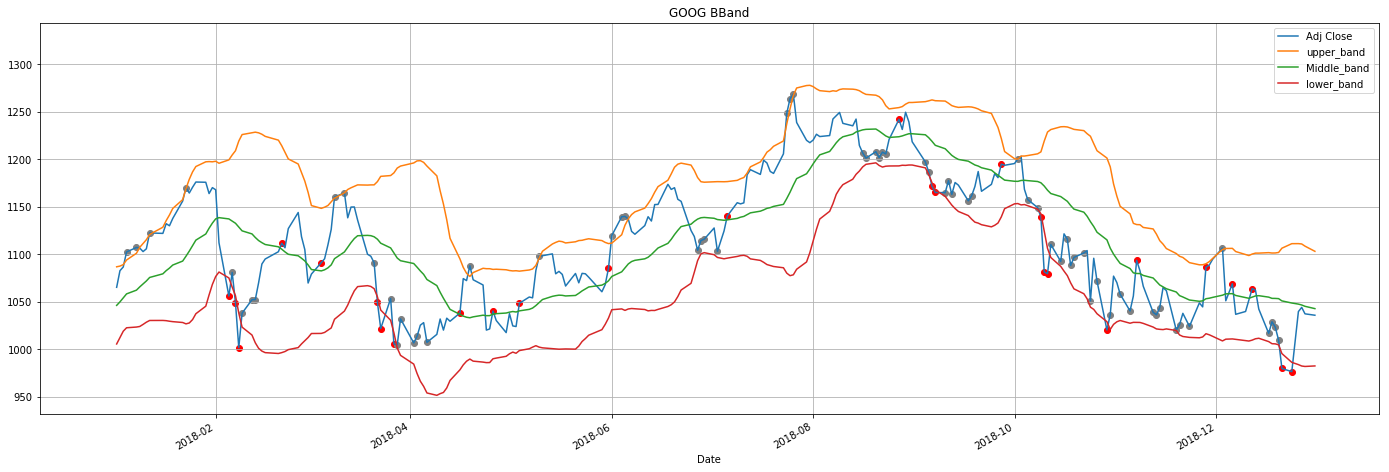

In [117]:
def getSignal(band):
    
    signals = pd.DataFrame(index=band.index)
    signals['Buy'] = None
    signals['Sell'] = None
    
#Four common rules

#     signals.loc[(band['Close'] < band['lower_band']), 'Buy'] = 1
#     signals.loc[(band['Close'] > band['upper_band']), 'Sell'] = 1

#     signals.loc[(band['Adj Close'] > band['Middle_band']) & (band['Adj Close'].shift(1) < band['Middle_band'].shift(1)), 'Buy'] = 1
#     signals.loc[(band['Adj Close'] < band['Middle_band']) & (band['Adj Close'].shift(1) > band['Middle_band'].shift(1)), 'Sell'] = 1
#     signals.loc[(band['Adj Close'] > band['lower_band']) & (band['Adj Close'].shift(1) < band['lower_band'].shift(1)), 'Buy'] = 1
#     signals.loc[(band['Adj Close'] < band['upper_band']) & (band['Adj Close'].shift(1) > band['upper_band'].shift(1)), 'Sell'] = 1
    
    signals.loc[(band['Adj Close'] > band['lower_band']) & (band['Adj Close'] < (band['Middle_band']-band['dev'])), 'Sell'] = 1
    signals.loc[(band['Adj Close'] > band['Middle_band']) & (band['Adj Close'].shift(1) < band['Middle_band'].shift(1)), 'Buy'] = 1
    signals.loc[(band['Adj Close'] < band['lower_band']), 'Buy'] = 1
    signals.loc[(band['Adj Close'] > band['upper_band']), 'Sell'] = 1
#     signals.loc[signals.index[0], 'Position'] = 0
#     signals.loc[signals['Buy'].shift(1) == 1, 'Position'] = 1
#     signals.loc[signals['Sell'].shift(1) == 1, 'Position'] = 0
#     signals['Position'].fillna(method='ffill', inplace=True)
    
    
#plot
    band.loc['2018'][['Adj Close','upper_band','Middle_band','lower_band']].plot(figsize=(24,8))
    plt.scatter(band.index, band['Adj Close']*(signals['Buy']==1), color='red')
    plt.scatter(band.index, band['Adj Close']*(signals['Sell']==1), color='grey')
    plt.grid()
    plt.ylim(min(band['lower_band'])-20)
    plt.title('GOOG BBand')
    
    

#Improvements
#Using dev to determine signal
#Consider holddays and stop loss rule
    
    return signals

signal = getSignal(band)


band.head()
signal.head()

In [118]:
# fig = plt.figure(figsize=(24, 8))
# ax = fig.add_subplot(1, 1, 1)
# data = data['2018']
# # ax.set_xticks(range(0, len(data['Date'][252:]), 20))
# ax.set_xticklabels(data.index)
# mpf.candlestick2_ochl(ax, data['Open'], data['Adj Close'], data['High'], data['Low'],
#                       width=0.5, colorup='r', colordown='green',
#                       alpha=0.6)

# ax2 = ax.twinx()
# ax2.set_xticklabels(data.index)
# ax2.plot(data['Open'])

In [119]:
def BackTest(signal, band, cash=5000000, shares=100000, per1=0.5, per2=0.6, se=1.9, sl=0.5):
    
    portfolio = band
    portfolio['Buy'] = signal['Buy']
    portfolio['Sell'] = signal['Sell']
    portfolio['value'] = cash + shares*band['Adj Close'][0] 
    portfolio['cash'] = cash  
    portfolio['holding'] =  shares*band['Adj Close'][0] 
    portfolio['position'] = shares 
    
    threshold = cash + shares*band['Adj Close'][0]
    
    portfolio = portfolio.reset_index()
    
    for i in portfolio.index[:-1]:
        if portfolio.iloc[i, 8]==1:
            portfolio.iloc[i+1, 13] = portfolio.iloc[i, 13] + portfolio.iloc[i, 11]*per1/portfolio.iloc[i+1, 2]
            portfolio.iloc[i+1, 12] = portfolio.iloc[i+1, 13]*portfolio.iloc[i+1, 1]
            portfolio.iloc[i+1, 11] = portfolio.iloc[i, 11]*(1-per1)
            portfolio.iloc[i+1, 10] = portfolio.iloc[i+1, 11] + portfolio.iloc[i+1, 12]
            threshold = portfolio.iloc[i+1, 12]
            
        elif portfolio.iloc[i, 9]==1:
            portfolio.iloc[i+1, 13] = portfolio.iloc[i, 13]*(1-per2)
            portfolio.iloc[i+1, 12] = portfolio.iloc[i+1, 13]*portfolio.iloc[i+1, 1]
            portfolio.iloc[i+1, 11] = portfolio.iloc[i, 11] + portfolio.iloc[i, 13]*per2*portfolio.iloc[i+1, 2]
            portfolio.iloc[i+1, 10] = portfolio.iloc[i+1, 11] + portfolio.iloc[i+1, 12]
            threshold = portfolio.iloc[i+1, 12]
        else:
            portfolio.iloc[i+1, 13] = portfolio.iloc[i, 13]
            portfolio.iloc[i+1, 12] = portfolio.iloc[i+1, 13]*portfolio.iloc[i+1, 1]
            portfolio.iloc[i+1, 11] = portfolio.iloc[i, 11]
            portfolio.iloc[i+1, 10] = portfolio.iloc[i+1, 11] + portfolio.iloc[i+1, 12]
            if portfolio.iloc[i+1, 12]>(se*threshold):
                portfolio.iloc[i+1, 8]=0
                portfolio.iloc[i+1, 9]=1
            if portfolio.iloc[i+1, 12]<(sl*threshold):
                portfolio.iloc[i+1, 9]=1
                portfolio.iloc[i+1, 8]=0
            
            
        portfolio['position change'] = portfolio['position'] - portfolio['position'].shift(1)
        portfolio['cash flow'] = portfolio['cash'] - portfolio['cash'].shift(1)
        portfolio['realized return'] = (portfolio['value'] - portfolio['value'][0])/portfolio['value'][0]
        portfolio['price change'] = (portfolio['Adj Close'] - portfolio['Adj Close'][0])/portfolio['Adj Close'][0]
        
    
    return portfolio


portfolio = BackTest(signal, band)
print(sum(portfolio['position change']!=0))
portfolio.head()



95


,Date,Adj Close,Open,Middle_band,dev,upper_band,lower_band,devchange,Buy,Sell,value,cash,holding,position,position change,cash flow,realized return,price change
0,2017-12-29,1046.400024,1046.719971,1043.602533,21.444908,1086.492349,1000.712717,NaN,None,None,1.096400e+08,5000000.0,1.046400e+08,100000.0,NaN,NaN,0.000000,0.000000
1,2018-01-02,1065.000000,1048.339966,1045.977365,20.309586,1086.596537,1005.358193,-1.135322,None,None,1.115000e+08,5000000.0,1.065000e+08,100000.0,0.0,0.0,0.016965,0.017775
2,2018-01-03,1082.479980,1064.310059,1049.671199,18.832250,1087.335698,1012.006699,-1.477336,None,None,1.132480e+08,5000000.0,1.082480e+08,100000.0,0.0,0.0,0.032908,0.034480
3,2018-01-04,1086.400024,1088.000000,1053.836730,17.525258,1088.887247,1018.786213,-1.306991,None,None,1.136400e+08,5000000.0,1.086400e+08,100000.0,0.0,0.0,0.036483,0.038226
4,2018-01-05,1102.229980,1094.000000,1058.069896,17.829846,1093.729588,1022.410205,0.304587,None,1,1.152230e+08,5000000.0,1.102230e+08,100000.0,0.0,0.0,0.050921,0.053354


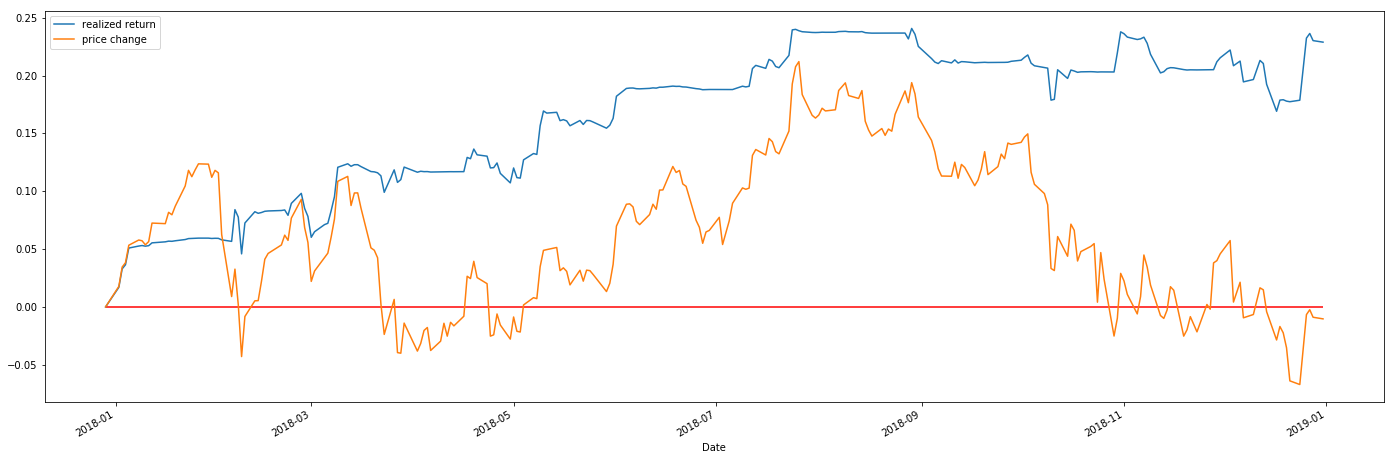

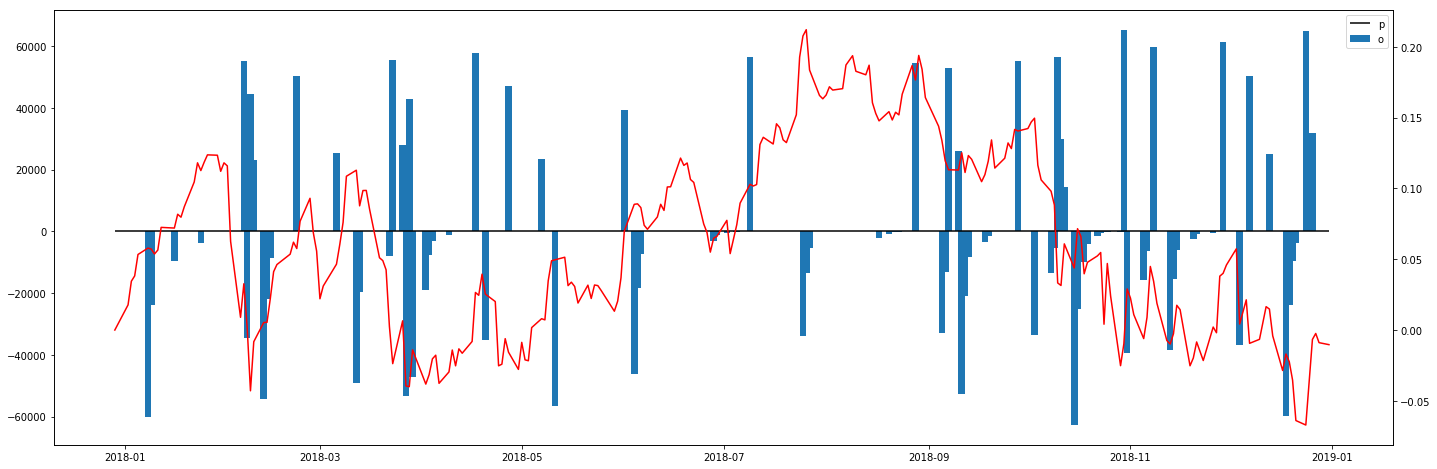

In [120]:
def getPlot(portfoliop):
    
    portfoliop = portfolio.set_index(['Date'])
    plt.figure(11, figsize=(24, 8))
#     portfoliop['value'].plot()
    portfoliop['realized return'].plot(legend='strategy rate of return')
    portfoliop['price change'].plot(legend='wer')
    plt.hlines(0, min(portfoliop.index), max(portfoliop.index), color='red')
    plt.show()
    
    
    fig = plt.figure(figsize=(24, 8))
    ax = fig.add_subplot(1, 1, 1)
    
    
    ax.bar(portfoliop.index, portfoliop['position change'], width=2)
    plt.hlines(0, min(portfoliop.index), max(portfoliop.index), color='black')
    ax.legend('position change')
    
    ax2 = ax.twinx()
    ax2.plot(portfoliop['price change'], color='red')
    plt.show()

getPlot(portfolio)

In [121]:
# ts.get_tick_data('AAPL', '2018-09-04')

In [122]:
# !pip install alpha_vantage

In [207]:
# from alpha_vantage.timeseries import TimeSeries

In [208]:
# ts = TimeSeries(key='9AMR2903VMD8PK5E',output_format='pandas')

In [64]:
# data, metadata = ts.get_intraday(symbol='AAPL',interval='1min', outputsize='full')

In [66]:
# data